<a href="https://colab.research.google.com/github/yy447/AL_framework/blob/main/AL_simulation_ch07152025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

**Step 1. Data Generation**

*   **True phenotype**. Generate a true phenotype label S_true from X1, which acts as our gold standard for the phenotype.
  *   In CVD use case, candidate phenotypes we can try in real data (need to be something that is hard to accurately get using ICD alone):

      *   Smoking status
      *   Hypertension
      *   Chronic kidney disease
      *   Depression / mental health

*   **Observed phenotype**. Add noise to S_true to get a noisy version S_star, mimicking what we would get in real clinical settings from structured data alone.
  *   In CVD use case, take smoking status for example

      *   ICD codes for smoking status are available, but they have limited granularity and are often incompletely or inconsistently coded
        
*   **Downstream outcome**. Generate the downstream outcome Y from S_true and X2: here X2 will be an additional set of predictors.
  *   In CVD use case, Y is CVD, S_true is true smoking status, X2 can be age, gender, race, SBP, diabetes etc

*   **Simulation parameters to change**. When generating the data, there are a set of parameters we should control to see in what senario the proposed method works best.
  *  Sample size
  *  Dimensions: dimensions of X1 and X2
  *  Distributions: distributions of X1 and X2
  *  Conditional independence assumptions: consider this later
  *  Accuracy of phenotyping model: accuracy of S_star in classifying S_true, accuracy of X1 in classifying S_true
  *  Accuracy of outcome model: accuracy of S_star and X2 in predicting Y




In [ ]:
def generate_patients_ch(
    n=1000,
    d_X1=10,
    d_X2=10,
    beta_S_scale=1.5,
    S_star_scale=2,
    beta_Y_scale_X2=0.2,
    beta_Y_scale_S=1.2,
    seed=123,
):
    np.random.seed(seed)

    # X1: for phenotype (S_true)
    X1 = np.random.normal(size=(n, d_X1))

    # X2: for outcome (Y)
    X2 = np.random.normal(size=(n, d_X2))

    # X1 -> S_true
    beta_S = np.random.randn(d_X1) * beta_S_scale
    s_logit = X1 @ beta_S + np.random.normal(scale=0.3, size=n)
    p_S = 1 / (1 + np.exp(-s_logit))
    S_true = np.random.binomial(1, p_S)
    auc_s = roc_auc_score(S_true, p_S)

    # S_true -> S_star ## the larger the scale, the lower the AUC
    s_star_logit = S_true + np.random.normal(scale=S_star_scale, size=n)
    S_star = 1 / (1 + np.exp(-s_star_logit))
    auc_sstar = roc_auc_score(S_true, S_star)

    # S_true + X2 -> Y
    y_coef_s = beta_Y_scale_S  # fixed effect of S_true # the larger the beta, the lower the AUC
    y_coef_x2 = np.random.normal(scale=beta_Y_scale_X2, size=X2.shape[1])  # random effects for X2
    y_logit = y_coef_s * S_true + X2 @ y_coef_x2 + np.random.normal(scale=0.5, size=n)  # add noise
    p_Y = 1 / (1 + np.exp(-y_logit))  # sigmoid
    Y = np.random.binomial(1, p_Y)  # binary outcome
    auc_y = roc_auc_score(Y, y_logit)

    return X1, X2, Y, S_true, S_star, auc_s, auc_sstar, auc_y

In [ ]:
generate_patients_ch(n=10, beta_S_scale=1.5,S_star_scale=2,beta_Y_scale_X2=1.2,beta_Y_scale_S=1.2)

(array([[-1.0856306 ,  0.99734545,  0.2829785 , -1.50629471, -0.57860025,
          1.65143654, -2.42667924, -0.42891263,  1.26593626, -0.8667404 ],
        [-0.67888615, -0.09470897,  1.49138963, -0.638902  , -0.44398196,
         -0.43435128,  2.20593008,  2.18678609,  1.0040539 ,  0.3861864 ],
        [ 0.73736858,  1.49073203, -0.93583387,  1.17582904, -1.25388067,
         -0.6377515 ,  0.9071052 , -1.4286807 , -0.14006872, -0.8617549 ],
        [-0.25561937, -2.79858911, -1.7715331 , -0.69987723,  0.92746243,
         -0.17363568,  0.00284592,  0.68822271, -0.87953634,  0.28362732],
        [-0.80536652, -1.72766949, -0.39089979,  0.57380586,  0.33858905,
         -0.01183049,  2.39236527,  0.41291216,  0.97873601,  2.23814334],
        [-1.29408532, -1.03878821,  1.74371223, -0.79806274,  0.02968323,
          1.06931597,  0.89070639,  1.75488618,  1.49564414,  1.06939267],
        [-0.77270871,  0.79486267,  0.31427199, -1.32626546,  1.41729905,
          0.80723653,  0.0454900

**AL framework**.
The function CVDALSystem_all includes all methods (with different sampling strategy) under comparision.

In [ ]:
class CVDALSystem_all:
    def __init__(
    self,
    X1,
    X2,
    Y_true,
    S_true,
    S_star,
    budget=200,
    batch_size=40,
    val_size=0.2,
    random_state=42,
    selection_strategy="hybrid",  # <-- ADD THIS
    ):

        # Split indices into training and validation sets
        indices = np.arange(len(X1))
        self.idx_train, self.idx_val = train_test_split(
            indices, test_size=val_size, stratify=Y_true, random_state=random_state
        )

        # Store training data
        self.X2_train = X2[self.idx_train]
        self.Y_train = Y_true[self.idx_train]
        self.S_train = S_star[self.idx_train].copy()  # continuous
        self.S_true_train = S_true[self.idx_train]  # binary
        self.label_budget = budget
        self.selection_strategy = selection_strategy
        self.batch_size = batch_size


        # Store validation data
        self.X2_val = X2[self.idx_val]
        self.Y_val = Y_true[self.idx_val]
        self.S_true_val = S_true[self.idx_val]

        # Standardize X2 features using training set
        self.scaler = StandardScaler().fit(self.X2_train)
        self.X2_train_scaled = self.scaler.transform(self.X2_train)
        self.X2_val_scaled = self.scaler.transform(self.X2_val)

        # AL setup
        self.budget = budget
        self.labeled_mask = np.zeros(len(self.idx_train), dtype=bool)
        self._init_seed_samples(random_state)
        self.selected_features = None

        # Classifier for downstream CVD prediction
        self.cvd_model = LogisticRegression(max_iter=1000)
        self.auc_history = []

        self._retrain()
    def learn_feature_weights(self, u_norm, g_norm, d_norm, Y_train, labeled_mask):
        """Learn weights for uncertainty, gain, and diversity using labeled data"""
        if labeled_mask.sum() < 20:
            return None  # Not enough data

        # Stack features
        X = np.vstack([u_norm[labeled_mask], g_norm[labeled_mask], d_norm[labeled_mask]]).T
        y = Y_train[labeled_mask]

        from sklearn.linear_model import LogisticRegression
        clf = LogisticRegression(max_iter=500)
        clf.fit(X, y)
        weights = clf.coef_[0]
        weights = weights / (np.abs(weights).sum() + 1e-8)  # Normalize

        return weights

    def _init_seed_samples(self, seed):
        """Select initial seed samples with balanced class distribution"""
        rng = np.random.RandomState(seed)
        pos_idx = np.where(self.S_true_train == 1)[0]
        neg_idx = np.where(self.S_true_train == 0)[0]
        n_per_class = min(15, len(pos_idx), len(neg_idx))

        # Sample positive and negative labels
        init_idx = np.concatenate(
            [
                rng.choice(pos_idx, n_per_class, replace=False),
                rng.choice(neg_idx, n_per_class, replace=False),
            ]
        )

        self.S_train[init_idx] = self.S_true_train[init_idx]
        self.labeled_mask[init_idx] = True

    def _retrain(self):
        """Train CVD model using current S_train"""
        Z_train = np.hstack([self.S_train.reshape(-1, 1), self.X2_train_scaled])

        self.cvd_model.fit(Z_train[self.labeled_mask], self.Y_train[self.labeled_mask])

        Z_val = np.hstack([self.S_true_val.reshape(-1, 1), self.X2_val_scaled])
        val_proba = self.cvd_model.predict_proba(Z_val)[:, 1]
        self.auc_history.append(roc_auc_score(self.Y_val, val_proba))

    def compute_knn_diversity(self, X2_train_scaled, k=5):
        if self.selected_features is None or len(self.selected_features) == 0:
            return np.random.rand(len(X2_train_scaled))

        actual_k = min(k, len(self.selected_features))
        try:
            nbrs = NearestNeighbors(n_neighbors=actual_k, algorithm="kd_tree")
            nbrs.fit(self.selected_features)
            distances, _ = nbrs.kneighbors(X2_train_scaled)

            mean_dist = distances.mean(axis=1)
            std_dist = distances.std(axis=1)
            diversity = 0.6 * mean_dist + 0.4 * std_dist

            progress = len(self.selected_features) / self.budget
            diversity *= np.exp(-2 * progress)

            return (diversity - diversity.min()) / (np.ptp(diversity) + 1e-8)

        except Exception as e:
            #print(f"多样性计算异常: {str(e)}")
            return np.random.rand(len(X2_train_scaled))

    def _compute_scores(self):
        """Calculate uncertainty, expected gain, and diversity for selection"""
        Z = np.hstack([self.S_train.reshape(-1, 1), self.X2_train_scaled])
        proba = self.cvd_model.predict_proba(Z)[:, 1]
        proba = np.clip(proba, 1e-10, 1 - 1e-10)
        # Uncertainty using entropy
        uncertainty = -proba * np.log(proba) - (1 - proba) * np.log(1 - proba)
        # AUC-based gain score (using similarity with previous batch)
        auc_gain = np.zeros_like(proba)
        if len(self.auc_history) >= 2:
            delta_auc = np.diff(self.auc_history[-2:])
            avg_gain = delta_auc.mean()
            if hasattr(self, "selection_history") and self.selection_history:
                last_batch = self.selection_history[-1]
                last_X2 = self.X2_train_scaled[np.isin(self.idx_train, last_batch)]
                similarity = self.X2_train_scaled.dot(last_X2.T).mean(axis=1)
                auc_gain = similarity * avg_gain
        # Diversity
        diversity = self.compute_knn_diversity(self.X2_train_scaled)
        return uncertainty, auc_gain, diversity



    def select_samples(self, batch_size=40):
        uncertainty, auc_gain, diversity = self._compute_scores()
        progress = self.labeled_mask.sum() / self.budget
        w_uncertainty = 0.4 * (1 - progress)
        w_diversity = 0.3 * (1 + progress)

        def safe_norm(x):
            x = np.nan_to_num(x)
            if np.ptp(x) < 1e-6:
                return np.zeros_like(x)
            return (x - np.min(x)) / np.ptp(x)


        u_norm = safe_norm(uncertainty)
        g_norm = safe_norm(auc_gain)
        d_norm = safe_norm(diversity)

        #combined = w_uncertainty * u_norm + 0.3 * g_norm + w_diversity * d_norm
                # --- New block: Strategy selection ---
        if self.selection_strategy == "random":
            combined = np.random.rand(len(uncertainty))
        elif self.selection_strategy == "uncertainty":
            combined = u_norm
        elif self.selection_strategy == "diversity":
            combined = d_norm
        else:  # default: hybrid
            combined = w_uncertainty * u_norm + 0.3 * g_norm + w_diversity * d_norm


        combined[self.labeled_mask] *= 0.2

        unlabeled = np.where(~self.labeled_mask)[0]
        min_new = max(1, int(batch_size * 0.2))
        new_candidates = unlabeled[np.argsort(-combined[unlabeled])[:min_new]]
        remaining = batch_size - len(new_candidates)

        top_k = np.concatenate([new_candidates, np.argsort(-combined)[:remaining]])[
            :batch_size
        ]

        new_features = self.X2_train_scaled[top_k]
        if self.selected_features is None:
            self.selected_features = new_features
        else:
            self.selected_features = np.vstack([self.selected_features, new_features])

        return top_k

    def al_step(self):
        if self.labeled_mask.sum() >= self.budget:
            return None
        batch_size=self.batch_size
        candidates = self.select_samples(batch_size)
        actual_batch = min(len(candidates), self.budget - self.labeled_mask.sum())
        selected = candidates[:actual_batch]

        self.S_train[selected] = self.S_true_train[selected]
        self.labeled_mask[selected] = True
        if not hasattr(self, "selected_features"):
            self.selected_features = self.X2_train_scaled[selected]
        else:
            self.selected_features = np.vstack(
                [self.selected_features, self.X2_train_scaled[selected]]
            )

        self._retrain()

        #print(
            #f"[AL Step] Labeled: {self.labeled_mask.sum()}/{self.budget} | "
            #f"AUC: {self.auc_history[-1]:.3f}"
        #)
        return self.auc_history[-1]

    def visualize(self):
        """Visualize AUC"""
        plt.figure(figsize=(6, 4))
        plt.plot(self.auc_history, marker="o", c="darkred")
        plt.title("Validation AUC Progress")
        plt.xlabel("AL Iterations")
        plt.ylabel("AUC")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


def visualize_summary(all_auc_histories):
    all_auc = np.array(
        [
            np.pad(
                run,
                (0, max(map(len, all_auc_histories)) - len(run)),
                constant_values=np.nan,
            )
            for run in all_auc_histories
        ]
    )

    mean_auc = np.nanmean(all_auc, axis=0)
    std_auc = np.nanstd(all_auc, axis=0)
    ci_auc = 1.96 * std_auc / np.sqrt(len(all_auc_histories))

    plt.figure(figsize=(6, 4))
    plt.plot(mean_auc, color="darkred", label="Mean AUC")
    plt.fill_between(
        np.arange(len(mean_auc)),
        mean_auc - ci_auc,
        mean_auc + ci_auc,
        color="darkred",
        alpha=0.2,
        label="95% CI",
    )
    plt.title("Validation AUC Progress")
    plt.xlabel("AL Iteration")
    plt.ylabel("AUC")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

**AL and RL framework**.

CVDALSystem_RL: here I updated the hybrid selection strategy so we use the auc of different sampling strategy to learn weights for the hybrid step. This is updated within each AL iteration, so we can phrase it as a reinforcement learning.

The RL can be further expanded by updating the clustering method within each step.

In [ ]:
class CVDALSystem_RL:
    def __init__(
        self,
        X1,
        X2,
        Y_true,
        S_true,
        S_star,
        budget=200,
        batch_size=40,
        val_size=0.2,
        random_state=42,
        selection_strategy="hybrid",
    ):
        indices = np.arange(len(X1))
        self.idx_train, self.idx_val = train_test_split(
            indices, test_size=val_size, stratify=Y_true, random_state=random_state
        )

        self.X2_train = X2[self.idx_train]
        self.Y_train = Y_true[self.idx_train]
        self.S_train = S_star[self.idx_train].copy()
        self.S_true_train = S_true[self.idx_train]
        self.label_budget = budget
        self.selection_strategy = selection_strategy
        self.batch_size = batch_size

        self.X2_val = X2[self.idx_val]
        self.Y_val = Y_true[self.idx_val]
        self.S_true_val = S_true[self.idx_val]

        self.scaler = StandardScaler().fit(self.X2_train)
        self.X2_train_scaled = self.scaler.transform(self.X2_train)
        self.X2_val_scaled = self.scaler.transform(self.X2_val)

        self.budget = budget
        self.labeled_mask = np.zeros(len(self.idx_train), dtype=bool)
        self._init_seed_samples(random_state)
        self.selected_features = None

        self.cvd_model = LogisticRegression(max_iter=1000)
        self.auc_history = []

        self._retrain()

    def _init_seed_samples(self, seed):
        rng = np.random.RandomState(seed)
        pos_idx = np.where(self.S_true_train == 1)[0]
        neg_idx = np.where(self.S_true_train == 0)[0]
        n_per_class = min(15, len(pos_idx), len(neg_idx))
        init_idx = np.concatenate([
            rng.choice(pos_idx, n_per_class, replace=False),
            rng.choice(neg_idx, n_per_class, replace=False),
        ])
        self.S_train[init_idx] = self.S_true_train[init_idx]
        self.labeled_mask[init_idx] = True

    def _retrain(self):
        Z_train = np.hstack([self.S_train.reshape(-1, 1), self.X2_train_scaled])
        self.cvd_model.fit(Z_train[self.labeled_mask], self.Y_train[self.labeled_mask])
        Z_val = np.hstack([self.S_true_val.reshape(-1, 1), self.X2_val_scaled])
        val_proba = self.cvd_model.predict_proba(Z_val)[:, 1]
        self.auc_history.append(roc_auc_score(self.Y_val, val_proba))

    def compute_knn_diversity(self, X2_train_scaled, k=5):
        if self.selected_features is None or len(self.selected_features) == 0:
            return np.random.rand(len(X2_train_scaled))

        actual_k = min(k, len(self.selected_features))
        nbrs = NearestNeighbors(n_neighbors=actual_k, algorithm="kd_tree")
        nbrs.fit(self.selected_features)
        distances, _ = nbrs.kneighbors(X2_train_scaled)
        mean_dist = distances.mean(axis=1)
        std_dist = distances.std(axis=1)
        diversity = 0.6 * mean_dist + 0.4 * std_dist
        progress = len(self.selected_features) / self.budget
        diversity *= np.exp(-2 * progress)
        return (diversity - diversity.min()) / (np.ptp(diversity) + 1e-8)

    def _compute_scores(self):
        Z = np.hstack([self.S_train.reshape(-1, 1), self.X2_train_scaled])
        proba = self.cvd_model.predict_proba(Z)[:, 1]
        proba = np.clip(proba, 1e-10, 1 - 1e-10)
        uncertainty = -proba * np.log(proba) - (1 - proba) * np.log(1 - proba)
        auc_gain = np.zeros_like(proba)
        diversity = self.compute_knn_diversity(self.X2_train_scaled)
        return uncertainty, auc_gain, diversity

    def _simulate_auc_gain_for_strategy(self, score_vector):
        candidates = np.argsort(-score_vector)
        temp_labeled = self.labeled_mask.copy()
        temp_S_train = self.S_train.copy()
        select_n = self.batch_size
        selected = [idx for idx in candidates if not temp_labeled[idx]][:select_n]
        if len(selected) < 5:
            return 0.0
        temp_labeled[selected] = True
        temp_S_train[selected] = self.S_true_train[selected]
        Z_temp = np.hstack([temp_S_train.reshape(-1, 1), self.X2_train_scaled])
        model = LogisticRegression(max_iter=1000)
        model.fit(Z_temp[temp_labeled], self.Y_train[temp_labeled])
        Z_val = np.hstack([self.S_true_val.reshape(-1, 1), self.X2_val_scaled])
        val_proba = model.predict_proba(Z_val)[:, 1]
        return roc_auc_score(self.Y_val, val_proba)

    def select_samples(self, batch_size=40):
        uncertainty, auc_gain, diversity = self._compute_scores()

        def safe_norm(x):
            x = np.nan_to_num(x)
            if np.ptp(x) < 1e-6:
                return np.zeros_like(x)
            return (x - np.min(x)) / np.ptp(x)

        u_norm = safe_norm(uncertainty)
        g_norm = safe_norm(auc_gain)
        d_norm = safe_norm(diversity)

        if self.selection_strategy == "random":
            combined = np.random.rand(len(uncertainty))
        elif self.selection_strategy == "uncertainty":
            combined = u_norm
        elif self.selection_strategy == "diversity":
            combined = d_norm
        else:
            auc_u = self._simulate_auc_gain_for_strategy(u_norm)
            auc_g = self._simulate_auc_gain_for_strategy(g_norm)
            auc_d = self._simulate_auc_gain_for_strategy(d_norm)
            aucs = np.array([auc_u, auc_g, auc_d])
            if np.ptp(aucs) < 1e-4:
                weights = np.array([1/3, 1/3, 1/3])
            else:
                weights = (aucs - np.min(aucs)) / (np.ptp(aucs) + 1e-8)
                weights /= weights.sum()
            combined = weights[0] * u_norm + weights[1] * g_norm + weights[2] * d_norm

        combined[self.labeled_mask] *= 0.2

        unlabeled = np.where(~self.labeled_mask)[0]
        min_new = max(1, int(batch_size * 0.2))
        new_candidates = unlabeled[np.argsort(-combined[unlabeled])[:min_new]]
        remaining = batch_size - len(new_candidates)
        top_k = np.concatenate([new_candidates, np.argsort(-combined)[:remaining]])[:batch_size]

        new_features = self.X2_train_scaled[top_k]
        if self.selected_features is None:
            self.selected_features = new_features
        else:
            self.selected_features = np.vstack([self.selected_features, new_features])

        return top_k

    def al_step(self):
        if self.labeled_mask.sum() >= self.budget:
            return None
        candidates = self.select_samples(self.batch_size)
        actual_batch = min(len(candidates), self.budget - self.labeled_mask.sum())
        selected = candidates[:actual_batch]
        self.S_train[selected] = self.S_true_train[selected]
        self.labeled_mask[selected] = True
        if not hasattr(self, "selected_features"):
            self.selected_features = self.X2_train_scaled[selected]
        else:
            self.selected_features = np.vstack([
                self.selected_features, self.X2_train_scaled[selected]
            ])
        self._retrain()
        return self.auc_history[-1]

    def visualize(self):
        plt.figure(figsize=(6, 4))
        plt.plot(self.auc_history, marker="o", c="darkred")
        plt.title("Validation AUC Progress")
        plt.xlabel("AL Iterations")
        plt.ylabel("AUC")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

def visualize_summary(all_auc_histories):
    all_auc = np.array([
        np.pad(run, (0, max(map(len, all_auc_histories)) - len(run)), constant_values=np.nan)
        for run in all_auc_histories
    ])
    mean_auc = np.nanmean(all_auc, axis=0)
    std_auc = np.nanstd(all_auc, axis=0)
    ci_auc = 1.96 * std_auc / np.sqrt(len(all_auc_histories))
    plt.figure(figsize=(6, 4))
    plt.plot(mean_auc, color="darkred", label="Mean AUC")
    plt.fill_between(
        np.arange(len(mean_auc)),
        mean_auc - ci_auc,
        mean_auc + ci_auc,
        color="darkred",
        alpha=0.2,
        label="95% CI",
    )
    plt.title("Validation AUC Progress")
    plt.xlabel("AL Iteration")
    plt.ylabel("AUC")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


== Running strategy: random ==

== Running strategy: uncertainty ==

== Running strategy: diversity ==

== Running strategy: hybrid_rl ==

== Running strategy: S_star_baseline ==

== Running strategy: S_true_oracle ==


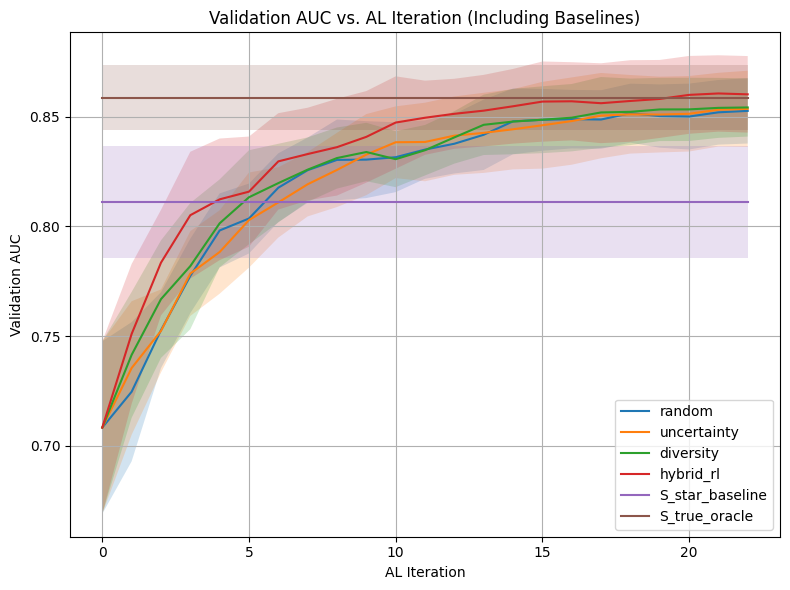


=== Final AUC Summary ===
            random: AUC = 0.853 ± 0.024 (n=10)
       uncertainty: AUC = 0.854 ± 0.028 (n=10)
         diversity: AUC = 0.854 ± 0.021 (n=10)
         hybrid_rl: AUC = 0.860 ± 0.028 (n=10)
   S_star_baseline: AUC = 0.811 ± 0.041 (n=10)
     S_true_oracle: AUC = 0.859 ± 0.024 (n=10)

=== Data Quality Summary ===
AUC(X1 → S_true)     : 0.949 ± 0.015
AUC(S_star → S_true) : 0.639 ± 0.017
AUC(S_true + X2 → Y) : 0.896 ± 0.013


In [ ]:
if __name__ == "__main__":
    strategies = ["random", "uncertainty", "diversity", "hybrid_rl", "S_star_baseline", "S_true_oracle"]
    strategy_auc_histories = {}


    auc_s_list = []
    auc_sstar_list = []
    auc_y_list = []

    for strategy in strategies:
        print(f"\n== Running strategy: {strategy} ==")
        all_auc_histories = []

        for run in range(10):
            X1, X2, Y, S_true, S_star, auc_s, auc_sstar, auc_y = generate_patients_ch(n=1000, seed=run, beta_S_scale=1.5,S_star_scale=2,beta_Y_scale_X2=0.2,beta_Y_scale_S=5)
            auc_s_list.append(auc_s)
            auc_sstar_list.append(auc_sstar)
            auc_y_list.append(auc_y)

            if strategy in ["S_star_baseline", "S_true_oracle"]:
                # Split into train/val
                from sklearn.model_selection import train_test_split
                from sklearn.linear_model import LogisticRegression
                from sklearn.metrics import roc_auc_score
                from sklearn.preprocessing import StandardScaler

                idx = np.arange(len(Y))
                idx_train, idx_val = train_test_split(idx, test_size=0.2, stratify=Y, random_state=run)

                X2_train, X2_val = X2[idx_train], X2[idx_val]
                scaler = StandardScaler().fit(X2_train)
                X2_train = scaler.transform(X2_train)
                X2_val = scaler.transform(X2_val)

                if strategy == "S_star_baseline":
                    S_used = S_star
                else:  # S_true_oracle
                    S_used = S_true

                Z_train = np.hstack([S_used[idx_train].reshape(-1, 1), X2_train])
                Z_val = np.hstack([S_true[idx_val].reshape(-1, 1), X2_val])  # Always evaluate on S_true

                model = LogisticRegression(max_iter=1000)
                model.fit(Z_train, Y[idx_train])
                proba_val = model.predict_proba(Z_val)[:, 1]
                auc_val = roc_auc_score(Y[idx_val], proba_val)
                padded_auc = [auc_val] * 10  # or max_len, or expected iteration count

                all_auc_histories.append([auc_val])  # Single-step history
                continue

            # Active learning strategies
            system = CVDALSystem_RL(
                X1, X2, Y, S_true, S_star,
                budget=200,
                batch_size=10,
                val_size=0.2,
                random_state=run,
                selection_strategy=strategy
            )

            while system.labeled_mask.sum() < system.budget:
                system.al_step()

            all_auc_histories.append(system.auc_history)

        strategy_auc_histories[strategy] = all_auc_histories

    # Compute max run length across all strategies
    max_len = max(len(run) for histories in strategy_auc_histories.values() for run in histories)

    plt.figure(figsize=(8, 6))
    for strategy, histories in strategy_auc_histories.items():
        # Repeat single-value histories to match max_len (for baseline strategies)
        for i, run in enumerate(histories):
            if len(run) == 1:
                histories[i] = run * max_len  # replicate the single AUC

        auc_array = np.array([
            np.pad(run, (0, max_len - len(run)), constant_values=np.nan)
            for run in histories
        ])
        mean_auc = np.nanmean(auc_array, axis=0)
        std_auc = np.nanstd(auc_array, axis=0)
        ci = 1.96 * std_auc / np.sqrt(len(histories))

        plt.plot(mean_auc, label=strategy)
        plt.fill_between(
            np.arange(len(mean_auc)),
            mean_auc - ci,
            mean_auc + ci,
            alpha=0.2
        )
    plt.title("Validation AUC vs. AL Iteration (Including Baselines)")
    plt.xlabel("AL Iteration")
    plt.ylabel("Validation AUC")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print("\n=== Final AUC Summary ===")
    for strategy, histories in strategy_auc_histories.items():
        final_aucs = [run[-1] if len(run) > 0 else np.nan for run in histories]
        mean_final_auc = np.nanmean(final_aucs)
        std_final_auc = np.nanstd(final_aucs)
        print(f"{strategy:>18}: AUC = {mean_final_auc:.3f} ± {std_final_auc:.3f} (n={len(final_aucs)})")

    print("\n=== Data Quality Summary ===")
    print(f"AUC(X1 → S_true)     : {np.mean(auc_s_list):.3f} ± {np.std(auc_s_list):.3f}")
    print(f"AUC(S_star → S_true) : {np.mean(auc_sstar_list):.3f} ± {np.std(auc_sstar_list):.3f}")
    print(f"AUC(S_true + X2 → Y) : {np.mean(auc_y_list):.3f} ± {np.std(auc_y_list):.3f}")
